In [ ]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

import arbitrary
reload(arbitrary)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values(system):
    SEED = 42

    I, J, J_sim = system.I, system.J, system.J_sim

    # Initial true state
    init = np.random.default_rng(SEED).uniform(size=I + I * J)

    u0 = jnp.array(init[:I])
    v0 = jnp.array(jnp.reshape(init[I:], (I, J)))

    # Initial simulation state
    u0_sim = jnp.zeros_like(u0)
    v0_sim = jnp.zeros((I, J_sim))

    return u0, v0, u0_sim, v0_sim


In [ ]:
import simultaneous
import arbitrary

reload(simultaneous)
reload(arbitrary)

# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
c1 *= 0.5
c2 *= 0.5
ds = jnp.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

# Simulation parameters
dt = 0.04
T0, Tf = 0, 1000
t_relax = 1

system = simultaneous.System(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)
solver = simultaneous.RK4(system)

bs = jnp.array([F, *ds])
γs = jnp.array([γ1, γ2])
cs = jnp.array([c1, c2])
newsystem = arbitrary.L96(μ, bs, γs, cs, I, J, J_sim)
newsolver = arbitrary.RK4(newsystem)

u0, v0, u0_sim, v0_sim = get_initial_values(system)

c1s = [system.c1]
c2s = [system.c2]
newcs = [newsystem.cs]

t0 = T0
tf = t0 + t_relax
U, V, Un, Vn = solver.solve(system, u0, v0, u0_sim, v0_sim, t0, tf, dt)
newU, newV, newUn, newVn = newsolver.solve(
    system, u0, v0, u0_sim, v0_sim, t0, tf, dt
)

c1, c2 = simultaneous.levenberg_marquardt(system, U[-1], Un[-1], Vn[-1])
c1s.append(c1.item())
c2s.append(c2.item())
system.c1 = c1s[-1]
system.c2 = c2s[-1]

newsystem.cs = arbitrary.levenberg_marquardt(
    newsystem, newU[-1], newUn[-1], newVn[-1]
)
newcs.append(newsystem.cs)

U[-1] - newU[-1], V[-1] - newV[-1], Un[-1] - newUn[-1], Vn[-1] - newVn[-1]

(Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
 Array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
   

In [ ]:
t0 = tf
tf = t0 + t_relax
U, V, Un, Vn = solver.solve(system, U[-1], V[-1], Un[-1], Vn[-1], t0, tf, dt)
newU, newV, newUn, newVn = newsolver.solve(
    system, newU[-1], newV[-1], newUn[-1], newVn[-1], t0, tf, dt
)

c1, c2 = simultaneous.levenberg_marquardt(system, U[-1], Un[-1], Vn[-1])
c1s.append(c1.item())
c2s.append(c2.item())
system.c1 = c1s[-1]
system.c2 = c2s[-1]

newsystem.cs = arbitrary.levenberg_marquardt(
    newsystem, newU[-1], newUn[-1], newVn[-1]
)
newcs.append(newsystem.cs)

In [ ]:
U[-1] - newU[-1], V[-1] - newV[-1], Un[-1] - newUn[-1], Vn[-1] - newVn[-1]

(Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
 Array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
   

In [ ]:
c1s, c2s, newcs

([0.005, 0.006412907093085509, 0.009123965850361838],
 [0.25, 0.25422054906982516, 0.25660264981289926],
 [Array([0.005, 0.25 ], dtype=float64),
  Array([0.00641291, 0.25422055], dtype=float64),
  Array([0.00899371, 0.25702205], dtype=float64)])

# Failing experiment below

In [ ]:
def simulate(system, solver, dt, T0, Tf, t_relax):
    t0 = T0
    tf = t0 + t_relax
    u0, v0, u0_sim, v0_sim = get_initial_values(system)

    cs = [system.cs]

    u_errors = []
    v_errors = []

    while tf <= Tf:
        U, V, Un, Vn = solver.solve(system, u0, v0, u0_sim, v0_sim, t0, tf, dt)

        u0, v0, u0_sim, v0_sim = U[-1], V[-1], Un[-1], Vn[-1]

        # Update parameters
        system.cs = arbitrary.levenberg_marquardt(system, u0, u0_sim, v0_sim)
        cs.append(system.cs)

        t0 = tf
        tf = t0 + t_relax

        # Relative error
        u_errors.append(
            np.linalg.norm(U - Un, axis=1) / np.linalg.norm(U, axis=1)
        )
        v_errors.append(
            np.linalg.norm(V - Vn, axis=(1, 2)) / np.linalg.norm(V, axis=(1, 2))
        )

    u_errors = np.concatenate(u_errors)
    v_errors = np.concatenate(v_errors)

    # Note `t0` is the actual final time of the simulation (Tf_actual).
    tls = np.linspace(T0, t0, len(u_errors) + 1)

    return jnp.stack(cs), u_errors, v_errors, tls


def plot(c1s, c2s, u_errors, v_errors, γ1, γ2, tls):
    num_iters = len(c1s)
    ils = np.arange(num_iters)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.hlines(γ1, ils[0], ils[-1], label="γ1", color="black")
    ax.plot(ils, c1s, label="c1")
    ax.legend()
    ax.set_title("c1 vs γ1")
    ax.set_xlabel("Iteration number")

    ax = axs[0, 1]
    ax.hlines(γ2, ils[0], ils[-1], label="γ2", color="black")
    ax.plot(ils, c2s, label="c2")
    ax.legend()
    ax.set_title("c2 vs γ2")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 0]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    ax = axs[1, 1]
    ax.plot(tls[1:], v_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $v$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
c1 *= 1
c2 *= 1
ds = jnp.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

bs = jnp.array([F, *ds])
γs = jnp.array([γ1, γ2])
cs = jnp.array([c1, c2])

system = arbitrary.L96(μ, bs, γs, cs, I, J, J_sim)
solver = arbitrary.RK4(system)

# Simulation parameters
dt = 0.04
T0, Tf = 0, 1000
t_relax = 1

cs, u_errors, v_errors, tls = simulate(
    system, solver, dt, T0, Tf, t_relax
)

/home/nschill/research-data-assimilation/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2832: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/home/nschill/research-data-assimilation/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2871: RuntimeWarning: overflow encountered in multiply
  ret = sqrt(add.reduce((x.conj() * x).real, axis=axis))


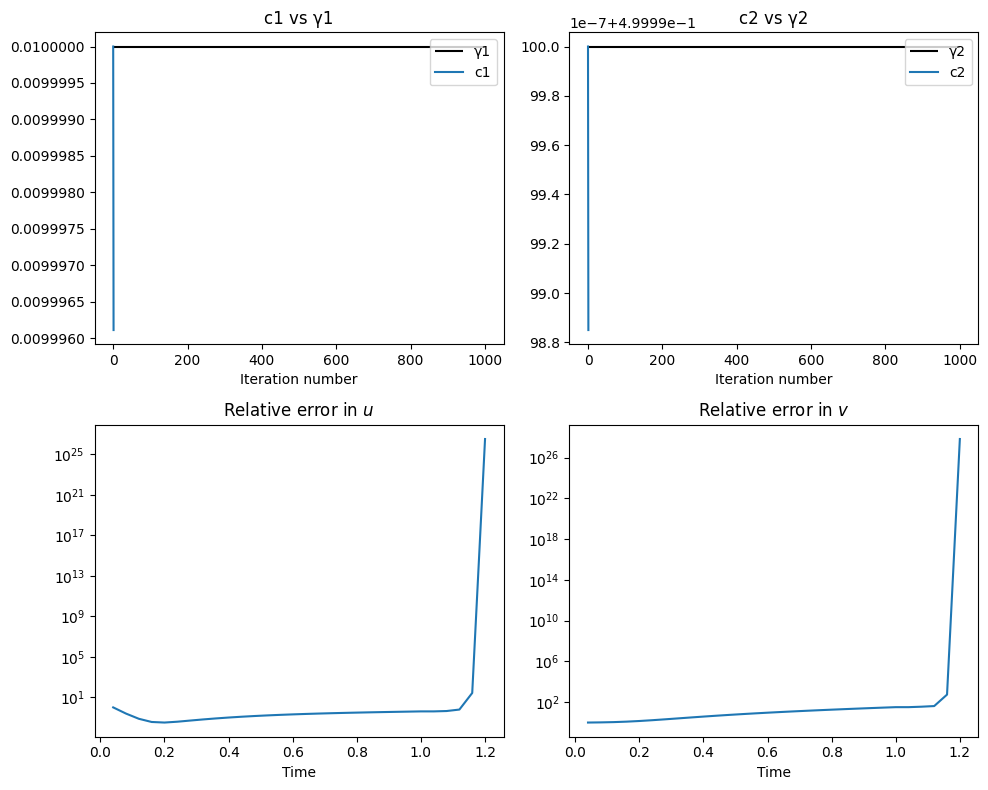

In [ ]:
fig, axs = plot(cs.T[0], cs.T[1], u_errors, v_errors, γ1, γ2, tls)
plt.show()